# Data Overview
_Author : Benjamin Ternot_

## I. Importing Libraries and Global Settings

In [32]:
#%pip install -r requirements.txt

#%pip freeze > requirements_weird.txt

In [33]:
#%pip install torchvision

In [1]:
import os
import gc
import datetime
import random

import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from PIL import ImageDraw, ImageFont
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader as TorchDataLoader, random_split
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

from data_manager.datamanager import DataLoader, DataDisplayer, DataTransformer
from data_manager.acdcloader import *
from models.model import Unet


from ControlNet.ControledUNet import * 
from ControlNet.Copy_weights import * 
from ControlNet.ControlNET import * 
from ControlNet.Full_Model import * 
from ControlNet.util import *

In [2]:
# Execution parameters
LIBERATE_MEMORY = True # Delete intermediate object to free memory space
GPU = 1

# Run of the notebook
TRAIN_MODEL = True
SAVE_MODEL = True
SAVE_INTERMEDIATE_MODELS = (False, 20)
LOAD_MODEL = not TRAIN_MODEL

TRAIN_FULL_MODEL = True
SAVE_FULL_MODEL = True
LOAD_FULL_MODEL = not TRAIN_MODEL

FULL_MODEL_LOAD_PATH = "models/trained_models/2025-02-10-15-06_4-channels_best-trained-ControlNet.pt"

MODEL_LOAD_PATH = "models/trained_models/2025-01-22-18-29_4-channels_best-trained-unet.pt"
PARAMS_LOAD_PATH = "models/parameters/2025-01-18-11-39_4-channels_params.txt"

# Parameters to use for the model
IMAGE_SIZE = 32
MULTI_CHANNEL = True
BATCH_SIZE = 64
EPOCHS = 50
T = 1000
DIM_MULTS = (1, 2, 4)#, 8)

In [3]:
# Modifier les couleurs des textes et des axes en fonction du thème de Jupyter
DARK_BG = False

if DARK_BG:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
else:
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'

In [4]:
current_datetime = datetime.datetime.now() 
SAVE_PATH = f"images/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + '4-channels' if MULTI_CHANNEL else '1-channel'
MODEL_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_trained-unet.pt"
MODEL_BEST_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_best-trained-unet.pt"
MODEL_INTERMEDIATE_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_epoch-{}-unet.pt"

PARAMS_SAVE_PATH = f"models/parameters/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_params.txt"

INPUT_SAVE_PATH = SAVE_PATH + "_batch_input.jpg"
OUTPUT_LOSS_MONITORING_PATH = SAVE_PATH + "_loss_monitoring.jpg"
OUTPUT_LOSS_MONITORING_LOG_PATH = SAVE_PATH + "_loss_monitoring_log.jpg"
OUTPUT_SAVE_PATH = SAVE_PATH + "_sampling.jpg"
OUTPUT_ONE_HOT_SAVE_PATH = SAVE_PATH + "_sampling_one-hot.jpg"
OUTPUT_GIF_SAVE_PATH = SAVE_PATH + "_sampling.gif.png"
OUTPUT_GIF_ONE_HOT_SAVE_PATH = SAVE_PATH + "_sampling_one-hot.gif.png"


FULL_MODEL_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_trained-ControlNet.pt"
FULL_MODEL_BEST_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_best-trained-ControlNet.pt"





In [5]:
if LOAD_MODEL:
    # Initialize an empty dictionary to hold the loaded parameters
    loaded_params = {}

    # Load parameters from the file
    with open(PARAMS_LOAD_PATH, "r") as file:
        for line in file:
            # Strip any whitespace and split key-value pairs
            key, value = line.strip().split(" = ")
            # Convert the value back to its original type (e.g., int, float, list, etc.)
            try:
                loaded_params[key] = eval(value)
            except:
                loaded_params[key] = value

    # Assign loaded parameters back to your variables
    IMAGE_SIZE = loaded_params.get("IMAGE_SIZE")
    MULTI_CHANNEL = loaded_params.get("MULTI_CHANNEL")
    BATCH_SIZE = loaded_params.get("BATCH_SIZE")
    EPOCHS = loaded_params.get("EPOCHS")
    T = loaded_params.get("T")
    DIM_MULTS = loaded_params.get("DIM_MULTS")

    print(f"Parameters loaded from '{PARAMS_LOAD_PATH}'\n")

    # Display loaded parameters
    print("Loaded Parameters:")
    for key, value in loaded_params.items():
        print(f"- {key}: {value} {type(value)}")

In [6]:
# Write parameters to the file

"""
SAVE_PARAMS = {
    "IMAGE_SIZE": IMAGE_SIZE,
    "MULTI_CHANNEL": MULTI_CHANNEL,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "T": T,
    "DIM_MULTS": DIM_MULTS
}
with open(PARAMS_SAVE_PATH, "w") as file:
    for key, value in SAVE_PARAMS.items():
        file.write(f"{key} = {value}\n")
print(f"Parameters saved to '{PARAMS_SAVE_PATH}'")
"""

'\nSAVE_PARAMS = {\n    "IMAGE_SIZE": IMAGE_SIZE,\n    "MULTI_CHANNEL": MULTI_CHANNEL,\n    "BATCH_SIZE": BATCH_SIZE,\n    "EPOCHS": EPOCHS,\n    "T": T,\n    "DIM_MULTS": DIM_MULTS\n}\nwith open(PARAMS_SAVE_PATH, "w") as file:\n    for key, value in SAVE_PARAMS.items():\n        file.write(f"{key} = {value}\n")\nprint(f"Parameters saved to \'{PARAMS_SAVE_PATH}\'")\n'

In [7]:
# Define the root data folder
root_data_folder = os.path.join(os.path.dirname(os.getcwd()), 'database')

# Define the sub path to the folders containing the data
data_sub_folders = {
    "train": "training",
    "test": "testing",
}

# Define the mapping from group labels to diagnostic classes
group_map = {
    "NOR": "Healthy control",
    "MINF": "Myocardial infarction",
    "DCM": "Dilated cardiomyopathy",
    "HCM": "Hypertrophic cardiomyopathy",
    "RV": "Abnormal right ventricle"
}

## Model Diffusion Process

In [8]:
DEVICE = torch.device(f"cuda:{GPU}") if torch.cuda.is_available() else "cpu"

print(DEVICE)

cuda:1


## Loading and Preprocessing

In [9]:
#%pip install --upgrade ipywidgets

In [10]:
from functools import partial
from data_manager.acdcloader import ACDCDataset, transform_image_and_mask, rotation_couple_images

transform_train = partial(transform_image_and_mask, image_size=IMAGE_SIZE, padding=0.01, make_dimension_mask=True)
augmentation_train = partial(rotation_couple_images, max_angle=45, nb_rotations = 7)

ds = ACDCDataset(data_path=root_data_folder, transform=transform_train, mode='training', augment=augmentation_train)

# Split the dataset into training and validation sets
train_size = BATCH_SIZE * int((0.9 * len(ds)//BATCH_SIZE)//1)  # 90% for training
val_size = len(ds) - train_size  # 10% for validation

print(f'{train_size} images ({train_size//BATCH_SIZE} batchs) for train, {val_size} images ({val_size//BATCH_SIZE} batchs) for validation. ({train_size/len(ds):.0%}-{val_size/len(ds):.0%})')
training_ds, val_ds = random_split(ds, [train_size, val_size])

Loading training data:   0%|          | 0/101 [00:00<?, ?it/s]

Loading slices:   0%|          | 0/100 [00:00<?, ?it/s]

Loaded 13314 slices in training mode.
11968 images (187 batchs) for train, 1346 images (21 batchs) for validation. (90%-10%)


In [11]:
train_dataloader = TorchDataLoader(training_ds, batch_size=BATCH_SIZE, shuffle=True)
channels = ds[0][1].shape[0]
image_size = ds[0][1].shape[1]
len_dataloader = len(ds)//BATCH_SIZE

val_dataloader = TorchDataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

def format_batch_shape_string(batch_shape: tuple[int]):
    return "{} image(s), {} channel(s), {} row(s), {} column(s)".format(*batch_shape)

batch_iterator = iter(train_dataloader)
batch_image, batch_mask, batch_id = next(batch_iterator)
#print(f"Shape of image batch: [{format_batch_shape_string(batch_image.shape)}]")
#print(f"Shape of mask batch: [{format_batch_shape_string(batch_mask.shape)}]")
#print(f"Number of images in the batch: {len(batch_id)}")

val_iterator = iter(val_dataloader)

In [40]:
print(f"Shape of mask batch: [{format_batch_shape_string(batch_mask.shape)}]")

Shape of mask batch: [64 image(s), 4 channel(s), 32 row(s), 32 column(s)]


In [12]:
def normalize_tensor_per_image(batch):
    # Normalize each image individually in the batch
    batch_normalized = torch.stack([2 * (image - image.min()) / (image.max() - image.min()) - 1 for image in batch])
    return batch_normalized

def show_images(batch, filename=None, one_hot_encode=False):
    image = np.array(torch.permute(make_grid(normalize_tensor_per_image(batch), nrow=int(np.sqrt(len(batch))), padding=0), (1,2,0)).cpu())
    image = (image + np.ones(image.shape))/2.
    if image.shape[-1] > 3:
        if one_hot_encode:
            image = DataDisplayer.one_hot_encode(image)
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].imshow(image[..., 1:4])
        axes[0].set_title("RGB Channels")
        axes[0].axis('off')
        im_bg = axes[1].imshow(image[..., 0], cmap='viridis')
        axes[1].set_title("Background Intensity")
        axes[1].axis('off')
        cbar = fig.colorbar(im_bg, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label("Intensity")
        plt.tight_layout()
        if filename:
            fig.savefig(filename)
        plt.show()
    else:
        plt.figure(figsize=(7, 7))
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        if filename:
            plt.savefig(filename)
        plt.show()

/tmp/ipykernel_1178838/709520779.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image = np.array(torch.permute(make_grid(normalize_tensor_per_image(batch), nrow=int(np.sqrt(len(batch))), padding=0), (1,2,0)).cpu())


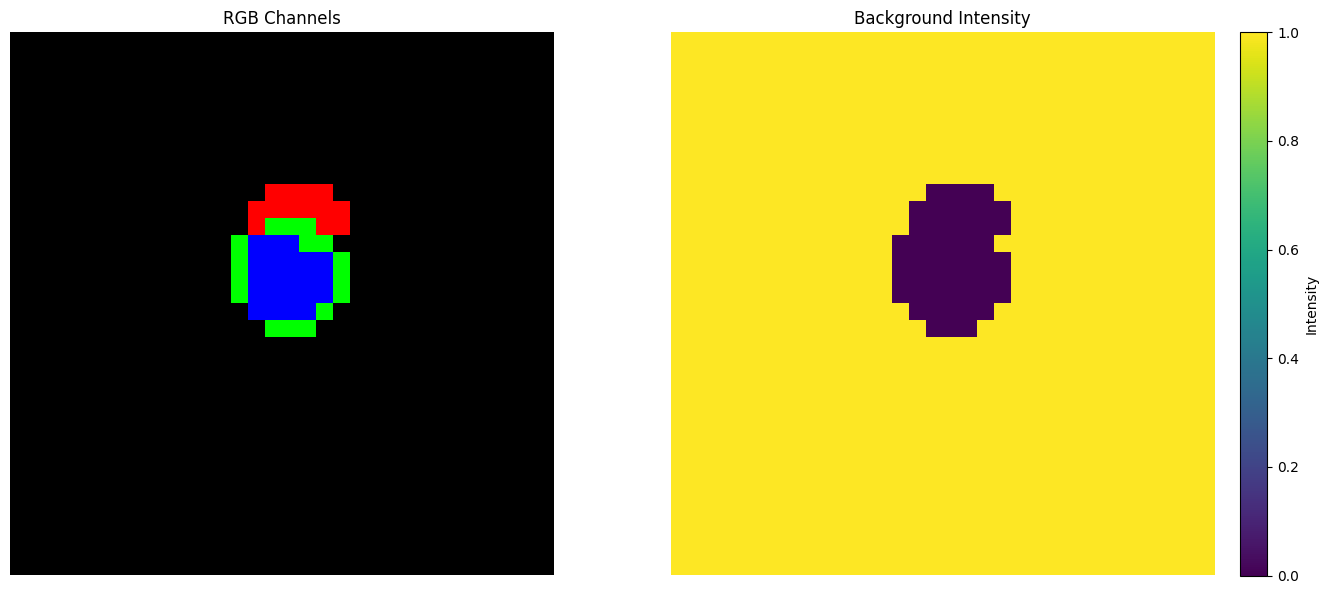

In [49]:
#show_images(batch_image[:])
show_images(batch_mask[0])
#print(batch_id)

## Forward Diffusion

### Beta Scheduling

In [14]:
"""
show_images(batch_image[:])
show_images(batch_mask[:])
print(batch_id)

batch_iterator = iter(train_dataloader)
batch_image, batch_mask, batch_id = next(batch_iterator)

"""



# Different type of beta schedule
def linear_beta_schedule(timesteps, beta_start = 0.0001, beta_end = 0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


### Constants calculation

In [15]:
# Function to get alphas and betas
def get_alph_bet(timesteps, schedule=cosine_beta_schedule):

    # define beta
    betas = schedule(timesteps)

    # define alphas
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0) # cumulative product of alpha
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # corresponding to the prev const
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # calculations for diffusion q(x_t | x_{t-1}) and others
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

    # calculations for posterior q(x_{t-1} | x_t, x_0)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    const_dict = {
        'betas': betas,
        'sqrt_recip_alphas': sqrt_recip_alphas,
        'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
        'posterior_variance': posterior_variance
    }

    return const_dict

### Definition of $q(x_t | x_{0})$

In [16]:
# extract the values needed for time t
def extract(constants, batch_t, x_shape):
    diffusion_batch_size = batch_t.shape[0]

    # get a list of the appropriate constants of each timesteps
    out = constants.gather(-1, batch_t.cpu())

    return out.reshape(diffusion_batch_size, *((1,) * (len(x_shape) - 1))).to(batch_t.device)


In [17]:
# forward diffusion (using the nice property)
def q_sample(constants_dict, batch_x0, batch_t, noise=None):
    if noise is None:
        noise = torch.randn_like(batch_x0)

    sqrt_alphas_cumprod_t = extract(constants_dict['sqrt_alphas_cumprod'], batch_t, batch_x0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_x0.shape
    )

    return sqrt_alphas_cumprod_t * batch_x0 + sqrt_one_minus_alphas_cumprod_t * noise

timesteps: tensor([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
        210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375, 390, 405,
        420, 435, 450, 465, 480, 495, 510, 525, 540, 555, 570, 585, 600, 615,
        630, 645, 660, 675, 690, 705, 720, 735, 750, 765, 780, 795, 810, 825,
        840, 855, 870, 885, 900, 915, 930, 945])
Original images:


/tmp/ipykernel_1178838/709520779.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image = np.array(torch.permute(make_grid(normalize_tensor_per_image(batch), nrow=int(np.sqrt(len(batch))), padding=0), (1,2,0)).cpu())


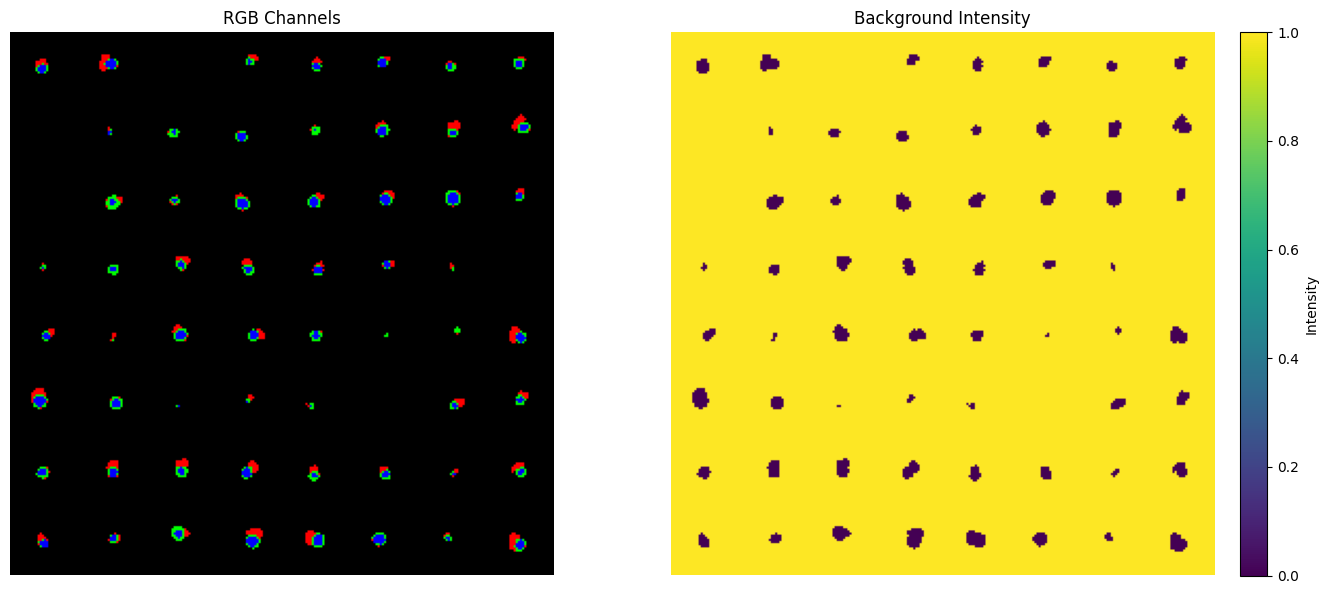

Noised images with linear shedule:


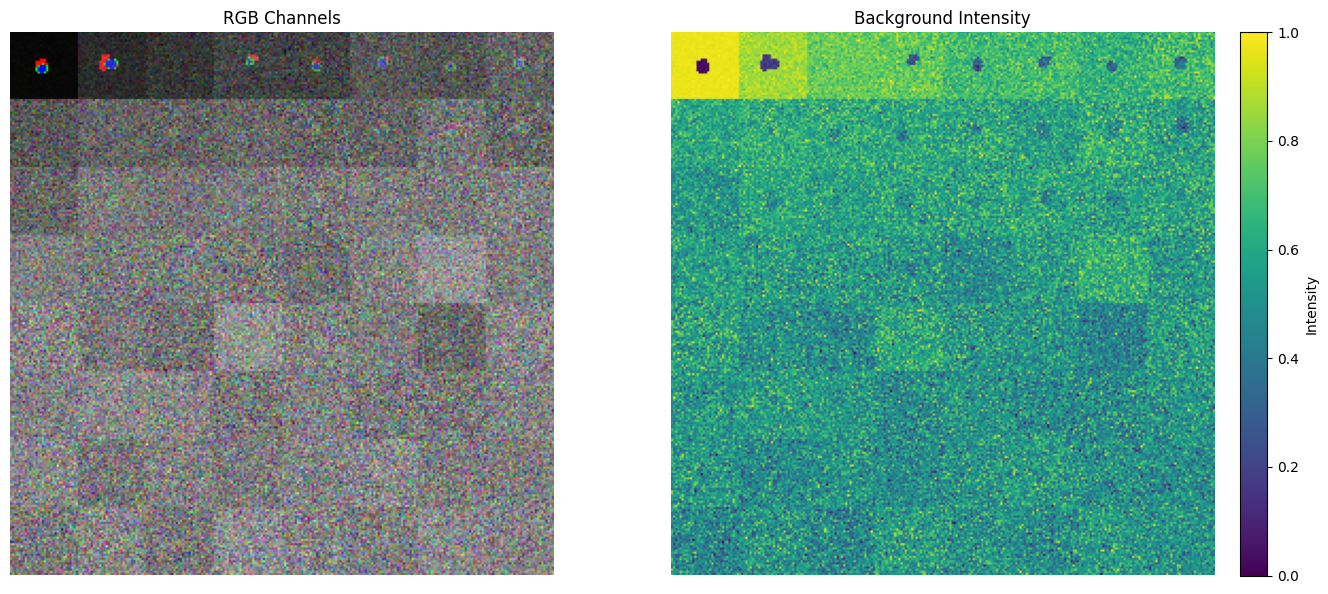

Noised images with cosine shedule:


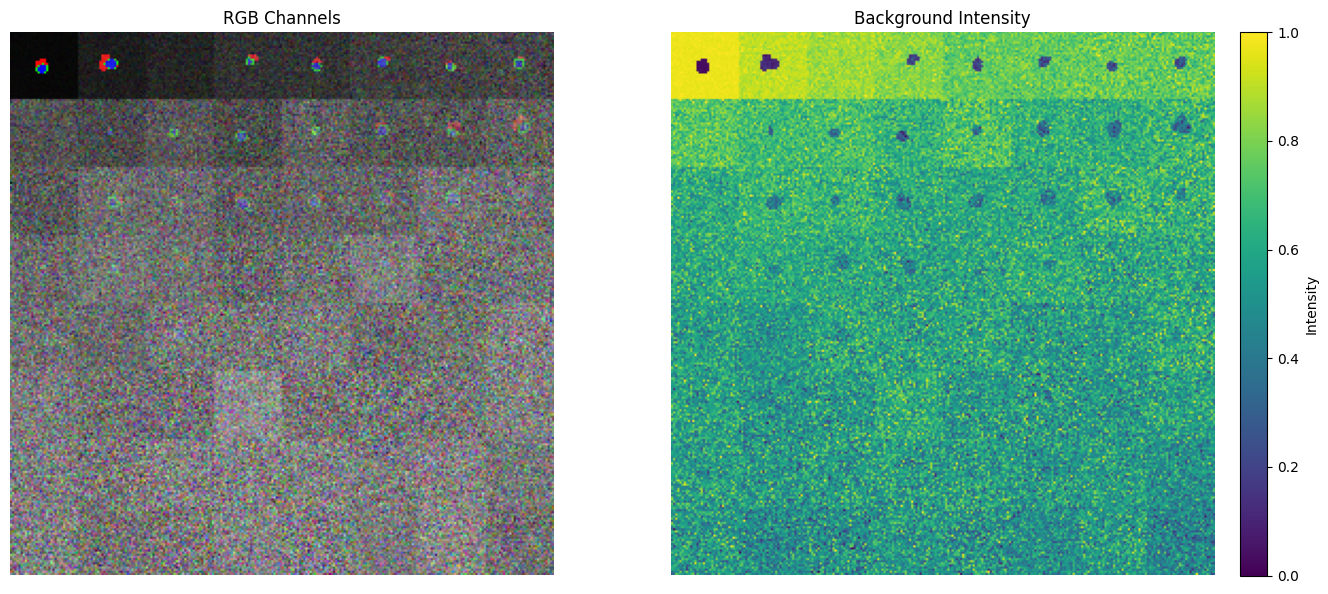

In [18]:

const_linear_dict = get_alph_bet(T, schedule=linear_beta_schedule)
const_cosine_dict = get_alph_bet(T, schedule=cosine_beta_schedule)

batch_t = torch.arange(BATCH_SIZE)*(T//BATCH_SIZE)  # get a range of timesteps from 0 to T
print(f"timesteps: {batch_t}")
noisy_batch_linear = q_sample(const_linear_dict, batch_mask, batch_t, noise=None)
noisy_batch_cosine = q_sample(const_cosine_dict, batch_mask, batch_t, noise=None)

print("Original images:")
show_images(batch_mask[:])

print("Noised images with linear shedule:")
show_images(noisy_batch_linear[:])

print("Noised images with cosine shedule:")
show_images(noisy_batch_cosine[:])

In [19]:
print(batch_mask[0].shape)

torch.Size([4, 32, 32])


## Model Diffusion Process

### Model definition

In [22]:
"""model = Unet(
        dim=image_size,
        init_dim=None,
        out_dim=None,
        dim_mults=DIM_MULTS,
        channels=channels,
        with_time_emb=True,
        convnext_mult=2,
    ).to(DEVICE)

"""

'model = Unet(\n        dim=image_size,\n        init_dim=None,\n        out_dim=None,\n        dim_mults=DIM_MULTS,\n        channels=channels,\n        with_time_emb=True,\n        convnext_mult=2,\n    ).to(DEVICE)\n\n'

### Definition of $ p_{\theta}(x_{t-1}|x_t) $

In [23]:
@torch.no_grad()
def p_sample(constants_dict, batch_xt, predicted_noise, batch_t):
    # We first get every constants needed and send them in right device
    betas_t = extract(constants_dict['betas'], batch_t, batch_xt.shape).to(batch_xt.device)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_xt.shape
    ).to(batch_xt.device)
    sqrt_recip_alphas_t = extract(
        constants_dict['sqrt_recip_alphas'], batch_t, batch_xt.shape
    ).to(batch_xt.device)

    # Equation 11 in the ddpm paper
    # Use predicted noise to predict the mean (mu theta)
    model_mean = sqrt_recip_alphas_t * (
        batch_xt - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )

    # We have to be careful to not add noise if we want to predict the final image
    predicted_image = torch.zeros(batch_xt.shape).to(batch_xt.device)
    t_zero_index = (batch_t == torch.zeros(batch_t.shape).to(batch_xt.device))

    # Algorithm 2 line 4, we add noise when timestep is not 1:
    posterior_variance_t = extract(constants_dict['posterior_variance'], batch_t, batch_xt.shape)
    noise = torch.randn_like(batch_xt)  # create noise, same shape as batch_x
    predicted_image[~t_zero_index] = model_mean[~t_zero_index] + (
        torch.sqrt(posterior_variance_t[~t_zero_index]) * noise[~t_zero_index]
    )

    # If t=1 we don't add noise to mu
    predicted_image[t_zero_index] = model_mean[t_zero_index]

    return predicted_image

## Sampling

#### - être sûr que c'est bien les images segmentées dont on gère la diffusion et que les images non segmentées et non bruitées n'interviennent qu'au bon moment 
 
- Ajouter le batch_image_testing et faire une petite loop pour laquelle je pars d'un noise au niveau du mask et je le génère en conditionnant à chaque step par le hint


In [24]:
# Algorithm 2 (including returning all images)
@torch.no_grad()
def sampling(model, shape, batch_image, T, constants_dict):
    b = shape[0]
    # start from pure noise (for each example in the batch)
    batch_xt = torch.randn(shape, device=DEVICE)

    batch_t = torch.ones(shape[0]) * T  # create a vector with batch-size time the timestep
    batch_t = batch_t.type(torch.int64).to(DEVICE)

    batch_hint = batch_image

    imgs = []

    for t in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        batch_t -= 1
        predicted_noise = model(batch_xt, batch_hint, batch_t)

        batch_xt = p_sample(constants_dict, batch_xt, predicted_noise, batch_t)

        imgs.append(batch_xt.cpu())

    return imgs

In [25]:
@torch.no_grad()
def sampling_model(model, shape, T, constants_dict):
    b = shape[0]
    # start from pure noise (for each example in the batch)
    batch_xt = torch.randn(shape, device=DEVICE)

    batch_t = torch.ones(shape[0]) * T  # create a vector with batch-size time the timestep
    batch_t = batch_t.type(torch.int64).to(DEVICE)

    imgs = []

    for t in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        batch_t -= 1
        predicted_noise = model(batch_xt, batch_t)

        batch_xt = p_sample(constants_dict, batch_xt, predicted_noise, batch_t)

        imgs.append(batch_xt.cpu())

    return imgs

In [26]:
### Training loop

## Training

In [27]:
## We already have declared in past cells:

## val_dataloader = TorchDataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

## batch_iterator = iter(train_dataloader)
## batch_image, batch_mask, batch_id = next(batch_iterator)

##channels = ds[0][1].shape[0]
##image_size = ds[0][1].shape[1]
##len_dataloader = len(ds)//BATCH_SIZE


## Old code redefinitions are not necessary but I keep them just in case

#train_dataloader, channels, image_size, len_dataloader = TorchDataLoader(dataset=training_images, batch_size=batch_size, shuffle=True), training_images[0].shape[0], target_shape[0], len(training_images)//batch_size
#val_dataloader = TorchDataLoader(val_images, batch_size=batch_size, shuffle=False)

constants_dict = get_alph_bet(T, schedule=linear_beta_schedule)


epochs = EPOCHS
learning_rate=1e-4
criterion = nn.SmoothL1Loss()


##This I will define after more precisely

#optimizer = Adam(model.parameters(), lr=1e-4)

### Training ControlNet



In [ ]:
"""  
def configure_optimizers(self):      ## Handles the locked U-NET part ??? (if not locked then add the parameters to the updating schedule)
        lr = self.learning_rate          ## If this is true, then these locked params are stored at model.diffusion_model.output_blocks.parameters() and at 
        params = list(self.control_model.parameters())   ## model.diffusion_model.out.parameters() which I have to check out
        if not self.sd_locked:            ## And also the parameters are control_model.parameters() which are different from self.model or self.cond_stage_model
            params += list(self.model.diffusion_model.output_blocks.parameters()) ## or self.first_stage_model
            params += list(self.model.diffusion_model.out.parameters())
        opt = torch.optim.AdamW(params, lr=lr)
        return opt
"""

from ControlNet.ControlNET import ControlNet


## Main model for which the forward will be the step
controlledunetmodel = ControlledUnetModel(
        dim=image_size,
        init_dim=None,
        out_dim=None,
        dim_mults=DIM_MULTS,
        channels=channels,
        with_time_emb=True,
        convnext_mult=2,
    ).to(DEVICE)

controlledunetmodel.load_state_dict(torch.load(MODEL_LOAD_PATH, weights_only=True, map_location=torch.device(DEVICE)))
controlledunetmodel.eval()

## Model for which the forward will be given as argument to 
##controlledunetmodel
controlnet = ControlNet(
        dim=image_size,
        init_dim=None,
        out_dim=None,
        dim_mults=DIM_MULTS,
        channels=channels,
        #hint_channels=1,
        with_time_emb=True,
        convnext_mult=2,
    ).to(DEVICE)


#missing_weights= ["zero_convs.0.weight", "zero_convs.0.bias", "zero_convs.1.weight", "zero_convs.1.bias", "zero_convs.2.weight", "zero_convs.2.bias", "zero_convs.3.weight", "zero_convs.3.bias", "input_hint_block.weight", "input_hint_block.bias", "middle_block_out.weight", "middle_block_out.bias"]
#for s in missing_weights
#dict = torch.load(MODEL_LOAD_PATH, weights_only=True, map_location=torch.device(DEVICE))

#for key in missingweights:
      # Disable gradient updates for efficiency
    #controlnet.zero_convs[0].weight.copy_(torch.randn_like(controlnet.zero_convs[0].weight))
    #controlnet.zero_convs[0].bias.copy_(torch.zeros_like(controlnet.zero_convs[0].bias))



controlnet.load_state_dict(torch.load(MODEL_LOAD_PATH, weights_only=True, map_location=torch.device(DEVICE)), strict=False)

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

controlnet.apply(init_weights)


controlnet.eval()

full_model = Full_Model(
       controlledunetmodel, controlnet
       
    ).to(DEVICE)



"""
def apply_model(self, x_noisy, t, cond, *args, **kwargs):
        assert isinstance(cond, dict)
        diffusion_model = self.model.diffusion_model


        if cond is None:
            eps = diffusion_model(x=x_noisy, timesteps=t, control=None)
            #
        else:
            control = controlnet(x=x_noisy, hint=torch.cat(cond['c_concat'], 1), timesteps=t)
            control = [c * scale for c, scale in zip(control, self.control_scales)]
            eps = diffusion_model(x=x_noisy, timesteps=t, control=control)



        return eps
"""

"""
def apply_forward_full_model(x,hint, time):
      control_output = controlnet(x,hint,time)
      full_model_output = controlledunetmodel(x,time,control_output)
      return full_model_output
"""

def configure_optimizers():      ## Handles the locked U-NET part ??? (if not locked then add the parameters to the updating schedule)
        lr = learning_rate         ## If this is true, then these locked params are stored at model.diffusion_model.output_blocks.parameters() and at 
        params = list(full_model.controlnet.parameters())   ## model.diffusion_model.out.parameters() which I have to check out
        

        excluded_params = set(id(p) for p in full_model.controlnet.ups.parameters())  # Get IDs of upsample parameters
        params_to_optimize = [p for p in full_model.parameters() if id(p) not in excluded_params]

        ## Enfait ici comme la partie up n'est pas utilisée dans le 
        ## forward et bien elle ne va pas être utilisée non ?

        # Define optimizer with the filtered parameters
        
        """
        if not self.sd_locked:            ## And also the parameters are control_model.parameters() which are different from self.model or self.cond_stage_model
            params += list(self.model.diffusion_model.output_blocks.parameters()) ## or self.first_stage_model
            params += list(self.model.diffusion_model.out.parameters())
        
        """
        

        optimizer = Adam(params_to_optimize, lr=1e-4)

        
        return optimizer

optimizer = configure_optimizers()

1
2


In [58]:
assert isinstance(controlledunetmodel, nn.Module), "controlledunetmodel must be an instance of nn.Module"
assert isinstance(controlnet, nn.Module), "controlnet must be an instance of nn.Module"

print(type(controlledunetmodel))
print(type(controlnet))

<class 'ControlNet.ControledUNet.ControlledUnetModel'>
<class 'ControlNet.ControlNET.ControlNet'>


In [59]:
print(isinstance(controlnet, nn.Module))  # Should print True
print(isinstance(controlledunetmodel, nn.Module))  # Should print True

True
True


# Training Loop for ControlNet

Epoch 1/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 2/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 3/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 4/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 5/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 6/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 7/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 8/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 9/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 10/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 11/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 12/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 13/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 14/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 15/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 16/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 17/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 18/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 19/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 20/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 21/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 22/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 23/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 24/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 25/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 26/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 27/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 28/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 29/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 30/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 31/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 32/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 33/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 34/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 35/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 36/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 37/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 38/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 39/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 40/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 41/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 42/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 43/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 44/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 45/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 46/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 47/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 48/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 49/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

Epoch 50/50:   0%|          | 0/187 [00:00<?, ?it/s]

batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
batch_t.shape: torch.Size([64])
noise.shape: torch.Size([64, 4, 32, 32])
batch_mask.shape: torch.Size([64, 4, 32, 32])
ba

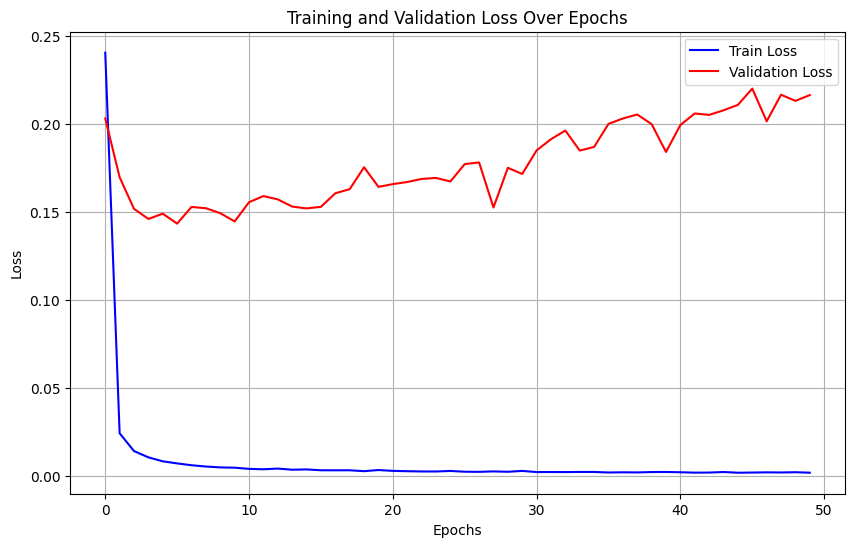

In [60]:
if TRAIN_FULL_MODEL:
    best_val_loss = float('inf')  # Start with an infinitely high loss
    best_model_state = None  # To save the best model
    last_model_state = None  # To save the last model
    best_epoch = 0

    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)

    # Create a fixed `T_val_steps` for validation (choose a specific time step range you want for validation)
    T_val_steps = torch.randint(0, T, (BATCH_SIZE,), device=DEVICE).long()  # fixed time steps for validation
    
    for epoch in range(epochs):
        full_model.train()
        train_loss = 0.0
        loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch_image, batch_mask, batch_id in loop:
            optimizer.zero_grad()

            batch_size_iter = batch_mask.shape[0]

            batch_mask = batch_mask.to(DEVICE)
            batch_mask = normalize_tensor_per_image(batch_mask)
            """à définir batch_hint
            """
            batch_hint = batch_image.to(DEVICE)

            # Algorithm 1 line 3: sample t uniformally for every example in the batch
            batch_t = torch.randint(0, T, (batch_size_iter,), device=DEVICE).long()

            noise = torch.randn_like(batch_mask)

            x_noisy = q_sample(constants_dict, batch_mask, batch_t, noise=noise)

           
            predicted_noise = full_model(x_noisy, batch_hint, batch_t)

            loss = criterion(noise, predicted_noise)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            loop.set_postfix(loss=loss.item())
        train_losses[epoch] = train_loss /len(train_dataloader)

        # After the training loop, calculate validation loss using fixed `T_val_steps`
        full_model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Don't compute gradients for validation
            for batch_image, batch_mask, batch_id in val_dataloader:
                
                
                batch_mask = batch_mask.to(DEVICE)
    
                # Use the fixed `T_val_steps` for validation (the same time steps across all validation batches)
                batch_t = T_val_steps  # Fixed time steps for validation

                batch_t = batch_t[:batch_mask.shape[0]]
    
                noise = torch.randn_like(batch_mask)

                batch_hint = batch_image.to(DEVICE)
    
                # Forward pass through the model
                print(f"batch_mask.shape: {batch_mask.shape}")
                print(f"batch_t.shape: {batch_t.shape}")
                print(f"noise.shape: {noise.shape}")


                x_noisy = q_sample(constants_dict, batch_mask, batch_t, noise=noise)
                predicted_noise = full_model(x_noisy, batch_hint, batch_t)
    
                # Compute the validation loss
                loss = criterion(noise, predicted_noise)
                val_loss += loss.item()
    
        val_loss /= len(val_dataloader)
        val_losses[epoch] = val_loss
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[epoch]:.4f}, Validation Loss: {val_losses[epoch]:.4f}")
    
        # Save the best model (with the lowest validation loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_full_model_state = full_model.state_dict()  # Save the best model's state
            best_epoch = epoch

    # Save the last model (after the final epoch)
    last_full_model_state = full_model.state_dict()

    # After training, plot the train and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), train_losses, label='Train Loss', color='blue')
    plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(OUTPUT_LOSS_MONITORING_PATH)
    plt.show()

    if SAVE_FULL_MODEL:
        torch.save(last_full_model_state, FULL_MODEL_SAVE_PATH)
        if best_epoch < epochs - 1:
            torch.save(best_full_model_state, FULL_MODEL_BEST_SAVE_PATH)

In [61]:
#print(batch_hint.shape)
#print(x_noisy.shape)
#print(batch_t.shape)

# Load best full model and previous model and compare them

In [52]:

from ControlNet.ControlNET import ControlNet
from models.model import Unet


model = Unet(
    dim=image_size,
        init_dim=None,
        out_dim=None,
        dim_mults=DIM_MULTS,
        channels=channels,
        with_time_emb=True,
        convnext_mult=2,
).to(DEVICE)

model.load_state_dict(torch.load(MODEL_LOAD_PATH, weights_only=True, map_location=torch.device(DEVICE)), strict=False)
model.eval()

## Main model for which the forward will be the step
controlledunetmodel = ControlledUnetModel(
        dim=image_size,
        init_dim=None,
        out_dim=None,
        dim_mults=DIM_MULTS,
        channels=channels,
        with_time_emb=True,
        convnext_mult=2,
    ).to(DEVICE)


## Model for which the forward will be given as argument to 
##controlledunetmodel
controlnet = ControlNet(
        dim=image_size,
        init_dim=None,
        out_dim=None,
        dim_mults=DIM_MULTS,
        channels=channels,
        #hint_channels=1,
        with_time_emb=True,
        convnext_mult=2,
    ).to(DEVICE)


#controlnet.load_state_dict(torch.load(MODEL_LOAD_PATH, weights_only=True, map_location=torch.device(DEVICE)), strict=False)


full_model = Full_Model(
       controlledunetmodel, controlnet
       
    ).to(DEVICE)

full_model.load_state_dict(torch.load(FULL_MODEL_LOAD_PATH, weights_only=True, map_location=torch.device(DEVICE)), strict=False)

full_model.eval()

1
2


Full_Model(
  (controlledunetmodel): ControlledUnetModel(
    (init_conv): Conv2d(4, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=32, out_features=128, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0): ConvNextBlock(
          (mlp): Sequential(
            (0): GELU(approximate='none')
            (1): Linear(in_features=128, out_features=20, bias=True)
          )
          (ds_conv): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=20)
          (net): Sequential(
            (0): GroupNorm(1, 20, eps=1e-05, affine=True)
            (1): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): GELU(approximate='none')
            (3): GroupNorm(1, 64, eps=1e-05, affine=True)
            (4): Conv2d(6

I have two trained models:

the first is 

model = Unet(
    dim=image_size,
        init_dim=None,
        out_dim=None,
        dim_mults=DIM_MULTS,
        channels=channels,
        with_time_emb=True,
        convnext_mult=2,
).to(DEVICE)

model.load_state_dict(torch.load(MODEL_LOAD_PATH, weights_only=True, map_location=torch.device(DEVICE)), strict=False)


and the second is 

full_model = Full_Model(
       controlledunetmodel, controlnet
       
    ).to(DEVICE)

full_model.load_state_dict(torch.load(FULL_MODEL_LOAD_PATH, weights_only=True, map_location=torch.device(DEVICE)), strict=False)

full_model has a controlledunetmodel part which is a UNET like model, and a controlNET part which is only the downsampling part of the UNET.


I want to compare the weights of the two models, especially compare the two UNET parts, and the two downsampling parts. How can I do that ?



In [53]:
# Extract parameters from the standalone UNet
unet_state_dict = model.state_dict()

# Extract parameters from the controlled UNet part of full_model
controlled_unet_state_dict = full_model.controlledunetmodel.state_dict()

# Extract parameters from the controlnet part (downsampling)
controlnet_state_dict = full_model.controlnet.state_dict()

#### Différences de weights entre UNet de model et la partie Controlled_Unet_Model de Full_model

In [ ]:
for key in unet_state_dict:
    if key in controlled_unet_state_dict:
        diff = torch.abs(unet_state_dict[key] - controlled_unet_state_dict[key]).sum().item()
        print(f"{key}: Difference sum = {diff}")


## C'est censé être exactement les mêmes puisque je le freeze ......
## 

init_conv.weight: Difference sum = 14.72964859008789
init_conv.bias: Difference sum = 0.04579375684261322
time_mlp.1.weight: Difference sum = 13.57795524597168
time_mlp.1.bias: Difference sum = 0.24378108978271484
time_mlp.3.weight: Difference sum = 46.11469650268555
time_mlp.3.bias: Difference sum = 0.19206179678440094
downs.0.0.mlp.1.weight: Difference sum = 6.177437782287598
downs.0.0.mlp.1.bias: Difference sum = 0.034504279494285583
downs.0.0.ds_conv.weight: Difference sum = 4.934587001800537
downs.0.0.ds_conv.bias: Difference sum = 0.03450439125299454
downs.0.0.net.0.weight: Difference sum = 0.09118640422821045
downs.0.0.net.0.bias: Difference sum = 0.048424966633319855
downs.0.0.net.1.weight: Difference sum = 36.8703498840332
downs.0.0.net.1.bias: Difference sum = 0.09614330530166626
downs.0.0.net.3.weight: Difference sum = 0.42776572704315186
downs.0.0.net.3.bias: Difference sum = 0.13428173959255219
downs.0.0.net.4.weight: Difference sum = 88.27873992919922
downs.0.0.net.4.bias

In [57]:
for key in unet_state_dict:
    if key in controlnet_state_dict:
        diff = torch.abs(unet_state_dict[key] - controlnet_state_dict[key]).sum().item()
        print(f"{key}: Difference sum = {diff}")

for key in controlnet_state_dict:
    if key not in unet_state_dict:
        print(f"{key} value : {controlnet_state_dict[key]}")

init_conv.weight: Difference sum = 307.10784912109375
init_conv.bias: Difference sum = 0.9401617050170898
time_mlp.1.weight: Difference sum = 877.6243896484375
time_mlp.1.bias: Difference sum = 11.563481330871582
time_mlp.3.weight: Difference sum = 1786.166748046875
time_mlp.3.bias: Difference sum = 6.339838981628418
downs.0.0.mlp.1.weight: Difference sum = 284.2405700683594
downs.0.0.mlp.1.bias: Difference sum = 1.000445008277893
downs.0.0.ds_conv.weight: Difference sum = 165.23406982421875
downs.0.0.ds_conv.bias: Difference sum = 1.392677903175354
downs.0.0.net.0.weight: Difference sum = 0.4322025775909424
downs.0.0.net.0.bias: Difference sum = 0.42324909567832947
downs.0.0.net.1.weight: Difference sum = 1037.3837890625
downs.0.0.net.1.bias: Difference sum = 2.3412537574768066
downs.0.0.net.3.weight: Difference sum = 0.792253851890564
downs.0.0.net.3.bias: Difference sum = 0.30721819400787354
downs.0.0.net.4.weight: Difference sum = 951.5325927734375
downs.0.0.net.4.bias: Difference 

In [ ]:
average_abs_value = torch.mean(torch.abs(controlnet_state_dict[key])).item()

In [55]:
print("UNet model keys:", unet_state_dict.keys())
print("ControlNet model keys:", controlnet_state_dict.keys())

UNet model keys: odict_keys(['init_conv.weight', 'init_conv.bias', 'time_mlp.1.weight', 'time_mlp.1.bias', 'time_mlp.3.weight', 'time_mlp.3.bias', 'downs.0.0.mlp.1.weight', 'downs.0.0.mlp.1.bias', 'downs.0.0.ds_conv.weight', 'downs.0.0.ds_conv.bias', 'downs.0.0.net.0.weight', 'downs.0.0.net.0.bias', 'downs.0.0.net.1.weight', 'downs.0.0.net.1.bias', 'downs.0.0.net.3.weight', 'downs.0.0.net.3.bias', 'downs.0.0.net.4.weight', 'downs.0.0.net.4.bias', 'downs.0.0.res_conv.weight', 'downs.0.0.res_conv.bias', 'downs.0.1.mlp.1.weight', 'downs.0.1.mlp.1.bias', 'downs.0.1.ds_conv.weight', 'downs.0.1.ds_conv.bias', 'downs.0.1.net.0.weight', 'downs.0.1.net.0.bias', 'downs.0.1.net.1.weight', 'downs.0.1.net.1.bias', 'downs.0.1.net.3.weight', 'downs.0.1.net.3.bias', 'downs.0.1.net.4.weight', 'downs.0.1.net.4.bias', 'downs.0.2.fn.fn.to_qkv.weight', 'downs.0.2.fn.fn.to_out.0.weight', 'downs.0.2.fn.fn.to_out.0.bias', 'downs.0.2.fn.fn.to_out.1.weight', 'downs.0.2.fn.fn.to_out.1.bias', 'downs.0.2.fn.norm.w

## Print results as images

In [29]:
def make_gif(frame_list, filename, step=5, one_hot_encode=False):    
    to_pil = ToPILImage()
    
    frames = [np.array(torch.permute(make_grid(normalize_tensor_per_image(tens_im), nrow=int(np.sqrt(batch_size)), padding=0), (1,2,0)).cpu()) for tens_im in frame_list]
    frames = [(frame + np.ones(frame.shape))/2. for frame in frames]
    frames_to_include = frames[0::step]
    if len(frames) % step != 0:
        frames_to_include.append(frames[-1])
    if frames_to_include[0].shape[-1] > 3:
        if one_hot_encode:
            frames_to_include = [DataDisplayer.one_hot_encode(frame) for frame in frames_to_include]
        frames_to_include = [frame[..., 1:4] for frame in frames_to_include]
    frames_pil = [to_pil(frame) for frame in frames_to_include]
    frame_one = frames_pil[0]
    
    frame_one.save(filename, format="GIF", append_images=frames_pil[1::], save_all=True, duration=10, loop=0)

    return IPython.display.Image(filename=filename)

In [ ]:
print("check generation:")

a = 0
for batch_image, batch_mask, batch_id in val_dataloader:
    batch_image = batch_image.to(DEVICE)
    print(batch_image.shape)
    list_gen_imgs_full_model = sampling(full_model, (BATCH_SIZE, channels, image_size, image_size), batch_image,T, constants_dict)
    list_gen_imgs_model = sampling_model(model, (BATCH_SIZE, channels, image_size, image_size), T, constants_dict)

    print(f"batch numéro {a}") 
    print("\n")
    print("\n")
    print("IMAGES")
    show_images(batch_image, OUTPUT_SAVE_PATH,one_hot_encode=False)
    print("\n")
    print("\n")
    print("MODELE SEGMENTATION FULL_MODEL")
    show_images(list_gen_imgs_full_model[-1][:], OUTPUT_SAVE_PATH, one_hot_encode=False)
    print("\n")
    print("\n")
    print("VRAI MASQUE")
    show_images(batch_mask, OUTPUT_SAVE_PATH,one_hot_encode=False)
    print("\n")
    print("\n")
    print("MODELE GENERATIF MODEL")
    show_images(list_gen_imgs_model[-1][:], OUTPUT_SAVE_PATH, one_hot_encode=False)
    print("\n")
    print("\n")
    #show_images(list_gen_imgs[-1][:], OUTPUT_ONE_HOT_SAVE_PATH, one_hot_encode=True)
    a+=1
    if a == 5:
        break



SyntaxError: invalid syntax (4292210576.py, line 10)

In [ ]:
#plt.imshow(ex_rmi, alpha=1., cmap='gray')
#plt.imshow(ex_gt_4_bands[1:, ...].movedim(0, -1), alpha=0.5)

## Print segmentation result for validation set

In [ ]:

"""
This code print the different results for the generation of mask on heart IRM images

print("check generation:")

a = 0
for batch_image, batch_mask, batch_id in val_dataloader:
    batch_image = batch_image.to(DEVICE)
    print(batch_image.shape)
    list_gen_imgs_full_model = sampling(full_model, (BATCH_SIZE, channels, image_size, image_size), batch_image,T, constants_dict)
    list_gen_imgs_model = sampling(model, (BATCH_SIZE, channels, image_size, image_size), batch_image,T, constants_dict)
    show_images(list_gen_imgs_full_model[-1][:], OUTPUT_SAVE_PATH, one_hot_encode=False)
    show_images(batch_image, OUTPUT_SAVE_PATH,one_hot_encode=False)
    show_images(batch_mask, OUTPUT_SAVE_PATH,one_hot_encode=False)
    show_images(list_gen_imgs_model[-1][:], OUTPUT_SAVE_PATH, one_hot_encode=False)
    #show_images(list_gen_imgs[-1][:], OUTPUT_ONE_HOT_SAVE_PATH, one_hot_encode=True)
    a+=1
    if a == 5:
        break
"""


#I want to print the intersection over union score of the segmentation of the mask for the full_model, by comparing the sampling for each batch to the original 
# mask which is in batch_mask. Each mask is a 32*32 image with 4 channels, red, green, blue and black. Red, green and blue represent 3 classes of segmentation value and black just 
# represent null class
# The shape of the generated image is the same 


In [ ]:
import torch
import torch.nn.functional as F

def compute_iou(pred_mask, true_mask, num_classes=3):
    """
    Compute IoU score for each class and return the mean IoU.
    Args:
        pred_mask (torch.Tensor): The predicted mask of shape (B, C, H, W).
        true_mask (torch.Tensor): The ground truth mask of shape (B, C, H, W).
        num_classes (int): The number of segmentation classes.
    Returns:
        float: The mean IoU score across all classes.
    """
    iou_scores = []
    
    # Convert one-hot encoded masks to class indices
    #pred_class = torch.argmax(pred_mask, dim=1)
    #true_class = torch.argmax(true_mask, dim=1)


    for class_idx in range(1, 4):  # Ignore background (index 0)
        pred_class = pred_mask[:, class_idx, :, :]
        true_class = true_mask[:, class_idx, :, :]
        
        intersection = torch.sum(pred_class * true_class, dim=(1, 2))  # Sum over spatial dimensions
        union = torch.sum(pred_class, dim=(1, 2)) + torch.sum(true_class, dim=(1, 2)) - intersection
        
        iou = intersection / (union + 1e-6)  # Avoid division by zero
        iou_scores.append(iou)
    
    mean_iou = torch.stack(iou_scores).mean().item()

    """
    for cls in range(num_classes):
        pred_cls = (pred_class == cls)
        true_cls = (true_class == cls)
        
        intersection = torch.logical_and(pred_cls, true_cls).sum(dim=(1, 2))
        union = torch.logical_or(pred_cls, true_cls).sum(dim=(1, 2))
        
        iou = intersection.float() / (union.float() + 1e-6)
        iou_scores.append(iou)
    
    mean_iou = torch.stack(iou_scores).mean().item()
    """

    return mean_iou


In [ ]:
print("Check generation and compute IoU:")

a = 0
for batch_image, batch_mask, batch_id in val_dataloader:
    batch_image = batch_image.to(DEVICE)
    batch_mask = batch_mask.to(DEVICE)
    
    list_gen_imgs_full_model = sampling(full_model, (BATCH_SIZE, channels, image_size, image_size), batch_image, T, constants_dict)
    list_gen_imgs_model = sampling_model(model, (BATCH_SIZE, channels, image_size, image_size), T, constants_dict)
    gen_mask_full_model = list_gen_imgs_full_model[-1].to(DEVICE)  # Generated mask for full_model
    gen_mask_model = list_gen_imgs_model[-1].to(DEVICE)  # Generated mask for model
    
    
    iou_score_full_model = compute_iou(gen_mask_full_model, batch_mask, num_classes=3)
    iou_score_model = compute_iou(gen_mask_model, batch_mask, num_classes=3)
    print(f"Batch {a+1}: IoU Score Full Model = {iou_score_full_model:.4f}")
    print(f"Batch {a+1}: IoU Score Model = {iou_score_model:.4f}")
    
    a += 1
    if a == 5:
        break

Check generation and compute IoU:


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch 1: IoU Score Full Model = 0.0053
Batch 1: IoU Score Model = 0.0060


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch 2: IoU Score Full Model = 0.0069
Batch 2: IoU Score Model = 0.0071


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch 3: IoU Score Full Model = 0.0065
Batch 3: IoU Score Model = 0.0068


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch 4: IoU Score Full Model = 0.0063
Batch 4: IoU Score Model = 0.0064


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch 5: IoU Score Full Model = 0.0074
Batch 5: IoU Score Model = 0.0079
